**DOWNLOAD & LOAD THE DATASET**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d balraj98/indoor-training-set-its-residestandard

In [ ]:
! unzip indoor-training-set-its-residestandard.zip

In [ ]:
! kaggle datasets download -d wwwwwee/dehaze

In [ ]:
! unzip dehaze.zip

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Create new directories for the training and validation sets:

**NEW METHOD FOR SPLITTING AND MAPPING ALL DATASET**

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

base_dir = '/content'
indoor_dir = os.path.join(base_dir, 'IndoorSet')
outdoor_dir = os.path.join(base_dir, 'OutdoorSet')

train_hazy_dir = os.path.join(base_dir, 'train/hazy')
train_clear_dir = os.path.join(base_dir, 'train/clear')
val_hazy_dir = os.path.join(base_dir, 'val/hazy')
val_clear_dir = os.path.join(base_dir, 'val/clear')

os.makedirs(train_hazy_dir, exist_ok=True)
os.makedirs(train_clear_dir, exist_ok=True)
os.makedirs(val_hazy_dir, exist_ok=True)
os.makedirs(val_clear_dir, exist_ok=True)

In [ ]:
def split_dataset(clear_dir, hazy_dir, train_clear_dir, train_hazy_dir, val_clear_dir, val_hazy_dir, test_size=0.2, random_state=42):
    clear_files = sorted(os.listdir(clear_dir))
    hazy_files = sorted(os.listdir(hazy_dir))

    clear_train_files, clear_val_files = train_test_split(clear_files, test_size=test_size, random_state=random_state)

    for clear_file in clear_files:
        clear_id = os.path.splitext(clear_file)[0]
        matched_hazy_files = [hazy_file for hazy_file in hazy_files if hazy_file.startswith(clear_id + '_')]

        if clear_file in clear_train_files:
            shutil.copy(os.path.join(clear_dir, clear_file), os.path.join(train_clear_dir, clear_file))
            for matched_hazy_file in matched_hazy_files:
                shutil.copy(os.path.join(hazy_dir, matched_hazy_file), os.path.join(train_hazy_dir, matched_hazy_file))
        else:
            shutil.copy(os.path.join(clear_dir, clear_file), os.path.join(val_clear_dir, clear_file))
            for matched_hazy_file in matched_hazy_files:
                shutil.copy(os.path.join(hazy_dir, matched_hazy_file), os.path.join(val_hazy_dir, matched_hazy_file))

# Split IndoorSet into train and validation sets
indoor_clear_dir = os.path.join(indoor_dir, 'clear')
indoor_hazy_dir = os.path.join(indoor_dir, 'hazy')
split_dataset(indoor_clear_dir, indoor_hazy_dir, train_clear_dir, train_hazy_dir, val_clear_dir, val_hazy_dir)

# Split OutdoorSet into train and validation sets
outdoor_clear_dir = os.path.join(outdoor_dir, 'clear_images')
outdoor_hazy_dir = os.path.join(outdoor_dir, 'haze')
split_dataset(outdoor_clear_dir, outdoor_hazy_dir, train_clear_dir, train_hazy_dir, val_clear_dir, val_hazy_dir)


In [ ]:
def reside_data_generator(hazy_dir, clear_dir, batch_size, img_size, shuffle=True):
    hazy_files = sorted(os.listdir(hazy_dir))
    clear_files = sorted(os.listdir(clear_dir))

    file_mapping = []
    for clear_file in clear_files:
        clear_id = os.path.splitext(clear_file)[0]
        matched_hazy_files = [hazy_file for hazy_file in hazy_files if hazy_file.startswith(clear_id + '_')]
        for matched_hazy_file in matched_hazy_files:
            file_mapping.append((matched_hazy_file, clear_file))

    if shuffle:
        np.random.shuffle(file_mapping)

    while True:
        for i in range(0, len(file_mapping), batch_size):
            batch_files = file_mapping[i:i+batch_size]
            batch_hazy_imgs = []
            batch_clear_imgs = []
        for hazy_file, clear_file in batch_files:
            hazy_img = Image.open(os.path.join(hazy_dir, hazy_file)).resize(img_size)
            clear_img = Image.open(os.path.join(clear_dir, clear_file)).resize(img_size)

            hazy_img = np.array(hazy_img) / 127.5 - 1.0
            clear_img = np.array(clear_img) / 127.5 - 1.0

            batch_hazy_imgs.append(hazy_img)
            batch_clear_imgs.append(clear_img)

        yield np.array(batch_hazy_imgs), np.array(batch_clear_imgs)

**---END OF NEW CODE---**

In [ ]:
batch_size = 16
img_size = (256, 256)

train_gen = reside_data_generator(train_hazy_dir, train_clear_dir, batch_size, img_size)
val_gen = reside_data_generator(val_hazy_dir, val_clear_dir, batch_size, img_size)


Generator and Discriminator architectures


In [ ]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    k_init = tf.keras.initializers.glorot_uniform()
    b_init = tf.keras.initializers.zeros()
    regularizer = tf.keras.regularizers.l2(0.01)

    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)

                                    #### Encoding Layers #####
    conv_up = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
                                    
                                    #### Residual Layers #####
    conv1_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

                                            ##### Decoding Layers #####
    deconv = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    
    output = tf.keras.activations.relu(conc)

    outputs = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(output)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

def build_discriminator():
    input_hazy = tf.keras.layers.Input(shape=(256, 256, 3))
    input_clear = tf.keras.layers.Input(shape=(256, 256, 3))

    x = tf.keras.layers.concatenate([input_hazy, input_clear])

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=[input_hazy, input_clear], outputs=x)

Create the generator and discriminator models and Define the GAN model, loss functions, and optimizers:

In [ ]:
def build_combined_model(generator, discriminator):
    hazy_input = tf.keras.layers.Input(shape=(256, 256, 3))
    generated_image = generator(hazy_input)
    
    resized_hazy_input = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(hazy_input)
    resized_generated_image = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(generated_image)
    
    discriminator.trainable = False
    discriminator_output = discriminator([resized_hazy_input, resized_generated_image])

    return tf.keras.Model(inputs=hazy_input, outputs=[generated_image, discriminator_output])


generator = build_generator()
discriminator = build_discriminator()

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
l1_loss_object = tf.keras.losses.MeanAbsoluteError()

combined_model = build_combined_model(generator, discriminator)
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                       loss=[l1_loss_object, loss_object],
                       loss_weights=[100, 1])

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss=loss_object)

combined_model.summary()

Implement the training loop. The training loop should include steps for training the discriminator and the generator:

In [ ]:
import os
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

def train_gan(train_gen, val_gen, num_epochs, steps_per_epoch, checkpoint_frequency=5):
    checkpoint_dir = './checkpoints'
    drive_dir = '/content/drive/MyDrive/DehazeModels/Trianed_Indoor_Outdoor'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    graph_disc_loss = []
    graph_gen_l1_loss = []
    graph_gen_adv_loss = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        epoch_disc_loss = []
        epoch_gen_l1_loss = []
        epoch_gen_adv_loss = []

        for step, (hazy_imgs, clear_imgs) in enumerate(train_gen):
            batch_size = hazy_imgs.shape[0]

            # Train the discriminator
            generated_imgs = generator.predict(hazy_imgs)
            real_labels = np.ones((batch_size, 32, 32, 1))
            fake_labels = np.zeros((batch_size, 32, 32, 1))

            real_loss = discriminator.train_on_batch([hazy_imgs, clear_imgs], real_labels)
            fake_loss = discriminator.train_on_batch([hazy_imgs, generated_imgs], fake_labels)
            disc_loss = 0.5 * (real_loss + fake_loss)
            epoch_disc_loss.append(disc_loss)

            # Train the generator (using the combined model)
            valid_labels = np.ones((batch_size, 32, 32, 1))
            combined_loss = combined_model.train_on_batch(hazy_imgs, [clear_imgs, valid_labels])
            epoch_gen_l1_loss.append(combined_loss[0])
            epoch_gen_adv_loss.append(combined_loss[1])

            if step >= steps_per_epoch - 1:
                break

        # Print epoch progress and any other metrics you'd like to track
        avg_disc_loss = np.mean(epoch_disc_loss)
        avg_gen_l1_loss = np.mean(epoch_gen_l1_loss)
        avg_gen_adv_loss = np.mean(epoch_gen_adv_loss)
        print(f"Discriminator loss: {avg_disc_loss:.4f}, Generator L1 loss: {avg_gen_l1_loss:.4f}, Generator adversarial loss: {avg_gen_adv_loss:.4f}")

        graph_disc_loss.append(avg_disc_loss)
        graph_gen_l1_loss.append(avg_gen_l1_loss)
        graph_gen_adv_loss.append(avg_gen_adv_loss)

        print("graph_disc_loss [] - ", graph_disc_loss)
        print("graph_gen_l1_loss [] - ", graph_gen_l1_loss)
        print("graph_gen_adv_loss [] - ", graph_gen_adv_loss)

        if (epoch + 1) % 10 == 0:

            # Plot the curves
            plt.plot(graph_disc_loss, 'r', label='Discriminator Loss')
            plt.plot(graph_gen_l1_loss, 'g', label='Generator L1 Loss')
            plt.plot(graph_gen_adv_loss, 'b', label='Generator Adversarial Loss')
            plt.legend()
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'GAN Loss Curves (Epoch {epoch + 1})')
            plt.savefig(f'./loss_curves_epoch_{epoch + 1}.png')
            plt.show()

        # Save model weights at checkpoints
        if (epoch + 1) % checkpoint_frequency == 0:

            checkpoint_path = os.path.join(checkpoint_dir, f'generator_{epoch + 1:04d}.h5')
            generator.save_weights(checkpoint_path)
            
            
            # Save model to drive
            drive_path = os.path.join(drive_dir, f'generator_{epoch + 1:04d}.h5')
            generator.save_weights(drive_path)
            
            # Save entire model to a HDF5 file
            # model.save('/content/drive/MyDrive/DehazeModels/generator_0010.h5')
            # model.save('/content/gdrive/My Drive/DehazeModels/my_model_dehaze.h5')

            print(f"Saved generator weights at {checkpoint_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train the GAN using the generators:

Epoch 1/10
1/1 [==============================] - 0s 26ms/step
Discriminator loss: 0.6996, Generator L1 loss: 91.2622, Generator adversarial loss: 0.7535
graph_disc_loss [] -  [0.6995837658643722]
graph_gen_l1_loss [] -  [91.26216354370118]
graph_gen_adv_loss [] -  [0.7535471022129059]
Epoch 2/10
1/1 [==============================] - 0s 42ms/step
Discriminator loss: 0.6980, Generator L1 loss: 78.7457, Generator adversarial loss: 0.6442
graph_disc_loss [] -  [0.6995837658643722, 0.6980486303567887]
graph_gen_l1_loss [] -  [91.26216354370118, 78.74572525024413]
graph_gen_adv_loss [] -  [0.7535471022129059, 0.6442199766635894]
Epoch 3/10
1/1 [==============================] - 0s 31ms/step
Discriminator loss: 0.6953, Generator L1 loss: 60.9038, Generator adversarial loss: 0.4757
graph_disc_loss [] -  [0.6995837658643722, 0.6980486303567887, 0.6952759027481079]
graph_gen_l1_loss [] -  [91.26216354370118, 78.74572525024413, 60.90384521484375]
graph_gen_adv_loss [] -  [0.7535471022129059, 0.

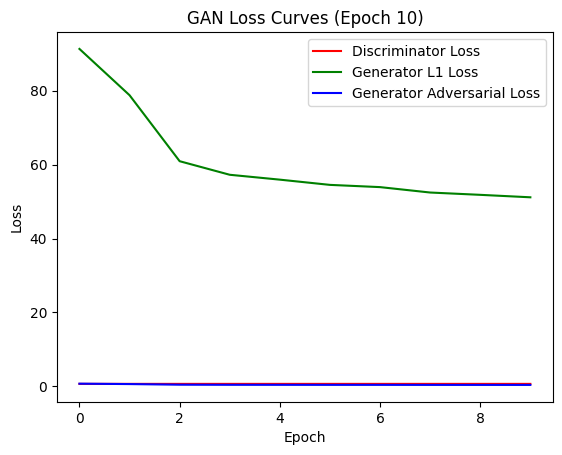

Saved generator weights at ./checkpoints/generator_0010.h5


In [ ]:
import math

num_epochs = 10
steps_per_epoch = math.ceil(10000 / 1000)
train_gan(train_gen, val_gen, num_epochs, steps_per_epoch)

**EVALUATION**

In [ ]:
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

weights_path = '/content/drive/MyDrive/DehazeModels/Trianed_Indoor_Outdoor/generator_0005.h5'
generator.load_weights(weights_path)

# Define path to test image
image_path = '/content/drive/MyDrive/Test_images/0468_1_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/0469_0.95_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/0471_0.95_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/1000_10_0.74905.png'
# image_path = '/content/drive/MyDrive/Test_images/1000_1_0.99837.png'

# image_path = '/content/Input/1000_10_0.74905.png'

# Evaluate image using the loaded model
# evaluation(generator, image_path)

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Load a hazy image
input_image_path = image_path
hazy_image = Image.open(input_image_path)

# Preprocess the hazy image
hazy_image = hazy_image.resize((256, 256))  # Resize the image to match the generator input size
hazy_image = np.array(hazy_image) / 127.5 - 1.0  # Scale pixel values to the range [-1, 1]
hazy_image = np.expand_dims(hazy_image, axis=0)  # Add a batch dimension

# Pass the preprocessed image through the generator
dehazed_image = generator.predict(hazy_image)

# Post-process the dehazed image
dehazed_image = np.squeeze(dehazed_image)  # Remove the batch dimension
dehazed_image = (dehazed_image + 1.0) * 127.5  # Rescale pixel values to the range [0, 255]
dehazed_image = np.clip(dehazed_image, 0, 255).astype(np.uint8)  # Clip values and convert to uint8

# Display or save the dehazed image
output_image_path = '/content/output-outdoor.jpg'
# output_image_path = '/content/output-indoor.png'
Image.fromarray(dehazed_image).save(output_image_path)

# Load the hazy and dehazed images as arrays
hazy_image = np.array(Image.open(input_image_path).resize((256, 256)))
dehazed_image = np.array(Image.open(output_image_path))

clear_img_path = '/content/OutdoorSet/clear_images/0468.jpg'
clear_image = np.array(Image.open(clear_img_path).resize((256, 256)))

# Calculate the PSNR and SSIM scores
psnr = peak_signal_noise_ratio(clear_image, dehazed_image)
ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)

# Print the scores
print('PSNR:', psnr)
print('SSIM:', ssim)

1/1 [==============================] - 0s 38ms/step
PSNR: 12.681397891443353
SSIM: 0.5302790961119127


<ipython-input-89-ea583e244af6>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)
